<p style="font-size:36px;text-align:center"> <b>Report(Impression) Generation from Chest X-Rays</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<p> Source: https://www.kaggle.com/ Currently the page is not available </p>

<p> Data_Source: http://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d 

http://academictorrents.com/details/66450ba52ba3f83fbf82ef9c91f2bde0e845aba9
 </p>

<h6> Problem statement : </h6>
<p> Generate impressions usinge chest X-ray image data of the patient and other information from reports </p>

<h2>1.2. Source/Useful Links</h2>

 Some articles and reference blogs about the problem statement

1. https://arxiv.org/pdf/1711.05225.pdf

2. https://arxiv.org/pdf/1703.09137.pdf
3. https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/
4. https://nlp.seas.harvard.edu/slides/emnlp16_bso.pdf
5. https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/download/16666/16283
6. https://towardsdatascience.com/processing-xml-in-python-elementtree-c8992941efd2

<h2>1.3. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is moderately important.
* Cost of mistake is high.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

- Data_Source: http://academictorrents.com/details/5a3a439df24931f410fac269b87b050203d9467d 

http://academictorrents.com/details/66450ba52ba3f83fbf82ef9c91f2bde0e845aba9
- We have two data compressed .tgz files: one contains the images of chext x-rays and othe contains reports of the patient containing patient information and impressions(Target variable)

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>
    
            The problem we are going to solve in this case study is Medical image captioning or report generation. 
Image captioning uses both Natural Language Processing(NLP) and Computer Vision(CV) to generate the text output.

   
      
    
</p>

<h3>2.2.2. Performance Metric</h3>


Metric(s): 
* BLEU score for different n-grams(1,2,3,4...) is a good metric in case of sequential output models.

<h2>2.3. Train, CV and Test Datasets</h2>

 Split the dataset randomly into three parts train, cross validation and test with 80%,10%, 10% of data respectively

<h1>3. Exploratory Data Analysis</h1>

<h2>3.1 Importing the required libraries <h>

In [9]:
import gdown
import tarfile
import xml.etree.ElementTree as ET
import os
import xml.dom.minidom
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns
import numpy as np
import regex as re
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from PIL import Image  
import tensorflow as tensorflow
import cv2 as cv
from keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.backend import expand_dims
from tensorflow import concat
tensorflow.compat.v1.enable_eager_execution()
tensorflow.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,Layer,Dropout
from tensorflow.keras.models import Model
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import repeat
from sklearn.utils import shuffle
import nltk.translate.bleu_score as bleu
from PIL import Image 
from google.colab.patches import cv2_imshow
import cv2
import tensorflow as tf
import time
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input

<h2> 3.2 Loading dataset <h2>

In [10]:
url = 'https://drive.google.com/uc?id=1--clwDc2F3_CF6O4EB_BnDewFjHmFL_7'
output = 'NLMCXR_png.tgz'
time.sleep(50)
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1--clwDc2F3_CF6O4EB_BnDewFjHmFL_7
To: /content/NLMCXR_png.tgz
1.36GB [00:13, 103MB/s] 


'NLMCXR_png.tgz'

In [3]:
url = 'https://drive.google.com/uc?id=1-0VfFtr8f1kc_xL19Z7Uzm74I_SzI3TX'
output = 'NLMCXR_reports.tgz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-0VfFtr8f1kc_xL19Z7Uzm74I_SzI3TX
To: /content/NLMCXR_reports.tgz
100%|██████████| 1.11M/1.11M [00:00<00:00, 115MB/s]


'NLMCXR_reports.tgz'

In [4]:
cwd = os.getcwd()

In [5]:
cwd

'/content'

In [11]:
tf1 = tarfile.open('NLMCXR_png.tgz')
tf1.extractall(cwd+'/png/')

In [12]:
tf1 = tarfile.open('NLMCXR_reports.tgz')
tf1.extractall(cwd+'/reports/')

<h3> 3.2.1 Checking the data stats <h3>

In [13]:
path, dirs, files = next(os.walk(cwd+"/png"))
print("Total number of images after extraction : " ,len(files)-1 )

path, dirs, files = next(os.walk(cwd+"/reports/ecgen-radiology"))
print("Total number of images after extraction : " ,len(files))

Total number of images after extraction :  7470
Total number of images after extraction :  3955


Observations :



*   There are 7470 images(X-rays) (one file is .db file )and 3955 reports in total.
*   So a few reports have more than image associated with them



In [14]:
#https://www.codespeedy.com/get-the-size-of-a-folder-in-python/
def get_size(path ):
   
    #initialize the size
    total_size = 0
    
    #use the walk() method to navigate through directory tree
    for dirpath, dirnames, filenames in os.walk(path):
        for i in filenames:
            
            #use join to concatenate all the components of path
            f = os.path.join(dirpath, i)
            
            #use getsize to generate size in bytes and add it to the total size
            total_size += os.path.getsize(f)

    return total_size

print("The size of the images is {} bytes ".format(get_size(cwd+'/png')))
print("The size of the reports is {} bytes ".format(get_size(cwd+'/reports')))

The size of the images is 1369616481 bytes 
The size of the reports is 20785154 bytes 


<h3> 3.2.2 Checking image sizes <h3>

In [15]:
width_list = []
height_list = []
for dirpath, dirnames, filenames in os.walk(cwd+'/png'):
  for i in filenames:
     f = os.path.join(dirpath, i)
     if(f == cwd+'/png/Thumbs.db' ):
       continue
     im = Image.open(f)
     width, height = im.size
     width_list.append(width)
     height_list.append(height)
print("Unique widths in the image sizes : ",len(set(width_list)))
print("Unique heights in the image sizes : ",len(set(height_list)))



Unique widths in the image sizes :  1
Unique heights in the image sizes :  304


Observations :



*   All the images have same width but not the same height
*   The images have to be re-sized according to i/p size of pre-trained image model input size.



<h3> 3.2.3 Display an XML <h3>

In [16]:
with open("/content/reports/ecgen-radiology/1008.xml", 'r') as f:
    print(f.read())

<?xml version="1.0" encoding="utf-8"?>
<eCitation>
   <meta type="rr"/>
   <uId id="CXR1008"/>
   <pmcId id="1008"/>
   <docSource>CXR</docSource>
   <IUXRId id="1008"/>
   <licenseType>open-access</licenseType>
   <licenseURL>http://creativecommons.org/licenses/by-nc-nd/4.0/</licenseURL>
   <ccLicense>byncnd</ccLicense>
   <articleURL/>
   <articleDate>2013-08-01</articleDate>
   <articleType>XR</articleType>
   <publisher>Indiana University</publisher>
   <title>Indiana University Chest X-ray Collection</title>
   <note>The data are drawn from multiple hospital systems.</note>
   <specialty>pulmonary diseases</specialty>
   <subset>CXR</subset>
   <MedlineCitation Owner="Indiana University" Status="supplied by publisher">
   
      <Article PubModel="Electronic">
      
         <Journal>
         
            <JournalIssue>
            
               <PubDate>
               
                  <Year>2013</Year>
               
                  <Month>08</Month>
               
   

Obervations :

The fields which seem to be important and userful are :



*   pmcid : Patient id 
*   COMPARISION
*   INDICATION 
*   FINDINGS
*   IMPRESSIONS ( Target Variable )
*   Image id (count of to track the number of images per report)





<h3> 3.2.4 Extracting information from XML & Creating Dataframe <h3>

In [17]:
img = []
patient_ids = []
img_impression = []
img_finding = []
for filename in tqdm(os.listdir(cwd+'/reports/ecgen-radiology')):
    if filename.endswith(".xml"):
        f = os.path.join(cwd+'/reports/ecgen-radiology',filename)
        
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'uId':
              patient = child.attrib['id']

            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') == 'FINDINGS':
                                        finding=name.text
                                        
        for p_image in root.findall('parentImage'):
            patient_ids.append(patient)
            
            img.append(p_image.get('id'))
            img_finding.append(finding)

In [18]:
dataset = pd.DataFrame()
dataset['patient_id'] = patient_ids
dataset['image_path'] = img
dataset['image_path'] = '/content/png/'+dataset['image_path']+'.png'
dataset['findings'] = img_finding

In [19]:
dataset.tail()

,patient_id,image_path,findings
7465,CXR3098,/content/png/CXR3098_IM-1450-1001.png,Heart size and mediastinal contours appear wit...
7466,CXR3098,/content/png/CXR3098_IM-1450-1002.png,Heart size and mediastinal contours appear wit...
7467,CXR1444,/content/png/CXR1444_IM-0286-1001.png,There is a healing fracture involving the left...
7468,CXR666,/content/png/CXR666_IM-2241-1001.png,The heart is mildly enlarged. The aorta is ath...
7469,CXR666,/content/png/CXR666_IM-2241-1002.png,The heart is mildly enlarged. The aorta is ath...


In [20]:
dataset.isnull().sum()

patient_id      0
image_path      0
findings      997
dtype: int64

<h3> 3.2.5 Number of images per patient <h3>

In [21]:
image_count_per_patient  = dataset.groupby(['patient_id']).size().reset_index(name='counts')

In [22]:
image_count_per_patient

,patient_id,counts
0,CXR1,2
1,CXR10,2
2,CXR100,2
3,CXR1000,3
4,CXR1001,2
...,...,...
3846,CXR995,2
3847,CXR996,2
3848,CXR997,2
3849,CXR998,2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Images per patient ')

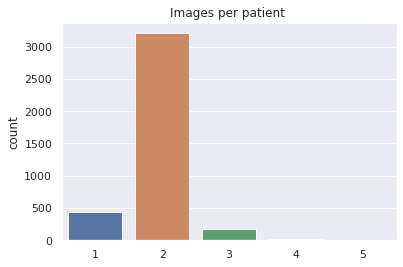

In [23]:
cnt=list(image_count_per_patient['counts'].values)
sns.set_theme(style="darkgrid")
sns.countplot(cnt)
plt.title("Images per patient ")

Observations:


*   In total there are 3851 unique patients
*   Morethan 3000 patients have two X-ray images associated with the reports
*   Around 500 patients have one X-rays asociated with the reports
*   Very few patients have more than 2 X-rays associated with the reports
*   So to capture most of the information we give input of two images to the model. as below



     1.If the patient has one X-ray associated with report we replicate same image twice as image1 and image2
     2.If the patient has two X-rays associated with the report we replicate first image as  image1 and second as image2
      3.If the patient has more than two  X-rays associated with the report we randomly chose 2 X-rays as image1 and image2






In [24]:
# In this block of code I am implementing above requirement

data = pd.DataFrame(columns=['patient_id','image1','image2','findings'])
i = 0
j = 0
while i<dataset.shape[0]:
  pt_id = dataset[i:i+1]['patient_id'].values[0]
  ct = image_count_per_patient[image_count_per_patient.patient_id == pt_id]['counts'].values[0]
  if ct==1:
    data.at[j,'patient_id'] = pt_id
    data.at[j,'image1'] = dataset[dataset.patient_id == pt_id]['image_path'].values[0]
    data.at[j,'image2'] = dataset[dataset.patient_id == pt_id]['image_path'].values[0]
    data.at[j,'findings'] = dataset[dataset.patient_id == pt_id]['findings'].values[0]

  elif ct==2:
    data.at[j,'patient_id'] = pt_id
    data.at[j,'image1'] = dataset[dataset.patient_id == pt_id]['image_path'].values[0]
    data.at[j,'image2'] = dataset[dataset.patient_id == pt_id]['image_path'].values[1]
    data.at[j,'findings'] = dataset[dataset.patient_id == pt_id]['findings'].values[0]

  else:
    choices = np.random.choice(ct,2)
    data.at[j,'patient_id'] = pt_id
    data.at[j,'image1'] = dataset[dataset.patient_id == pt_id]['image_path'].values[choices[0]]
    data.at[j,'image2'] = dataset[dataset.patient_id == pt_id]['image_path'].values[choices[1]]
    data.at[j,'findings'] = dataset[dataset.patient_id == pt_id]['findings'].values[0]
  
  i = i + ct
  j = j + 1


In [25]:
assert(data.shape[0] == image_count_per_patient.shape[0], 'True')

<ipython-input-25-d44ce18bf8c5>:1: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(data.shape[0] == image_count_per_patient.shape[0], 'True')


In [26]:
data.head()

,patient_id,image1,image2,findings
0,CXR3556,/content/png/CXR3556_IM-1741-1001-0001.png,/content/png/CXR3556_IM-1741-1001-0002.png,The lungs are clear. There is no pleural effus...
1,CXR1988,/content/png/CXR1988_IM-0645-1001.png,/content/png/CXR1988_IM-0645-3003.png,None
2,CXR32,/content/png/CXR32_IM-1511-1001.png,/content/png/CXR32_IM-1511-4001.png,The heart is normal in size. The mediastinum i...
3,CXR1414,/content/png/CXR1414_IM-0264-1001.png,/content/png/CXR1414_IM-0264-1002.png,None
4,CXR260,/content/png/CXR260_IM-1090-1001.png,/content/png/CXR260_IM-1090-2001.png,Lungs are clear bilaterally. Cardiac and media...


<h3> 3.2.6 Analysis & Preprocessing of text columns <h3>

In [27]:
data.isnull().sum()

patient_id      0
image1          0
image2          0
findings      514
dtype: int64

In [28]:
data = data.dropna(axis=0)

In [29]:
data.isnull().sum()

patient_id    0
image1        0
image2        0
findings      0
dtype: int64

Observations :



*   There are null values(None) in text columns
*   Will drop the columns with null value in impressions as it is the target variable and null values affect the prediction.





In [30]:
data.head()

,patient_id,image1,image2,findings
0,CXR3556,/content/png/CXR3556_IM-1741-1001-0001.png,/content/png/CXR3556_IM-1741-1001-0002.png,The lungs are clear. There is no pleural effus...
2,CXR32,/content/png/CXR32_IM-1511-1001.png,/content/png/CXR32_IM-1511-4001.png,The heart is normal in size. The mediastinum i...
4,CXR260,/content/png/CXR260_IM-1090-1001.png,/content/png/CXR260_IM-1090-2001.png,Lungs are clear bilaterally. Cardiac and media...
5,CXR1301,/content/png/CXR1301_IM-0198-1001.png,/content/png/CXR1301_IM-0198-2001.png,"Heart size within normal limits, stable medias..."
6,CXR1921,/content/png/CXR1921_IM-0598-1001.png,/content/png/CXR1921_IM-0598-2001.png,"Redemonstration of moderately-inflated lungs, ..."


In [31]:
data.head()

,patient_id,image1,image2,findings
0,CXR3556,/content/png/CXR3556_IM-1741-1001-0001.png,/content/png/CXR3556_IM-1741-1001-0002.png,The lungs are clear. There is no pleural effus...
2,CXR32,/content/png/CXR32_IM-1511-1001.png,/content/png/CXR32_IM-1511-4001.png,The heart is normal in size. The mediastinum i...
4,CXR260,/content/png/CXR260_IM-1090-1001.png,/content/png/CXR260_IM-1090-2001.png,Lungs are clear bilaterally. Cardiac and media...
5,CXR1301,/content/png/CXR1301_IM-0198-1001.png,/content/png/CXR1301_IM-0198-2001.png,"Heart size within normal limits, stable medias..."
6,CXR1921,/content/png/CXR1921_IM-0598-1001.png,/content/png/CXR1921_IM-0598-2001.png,"Redemonstration of moderately-inflated lungs, ..."


<h4> 3.2.6.1 Converting to lower case <h4>

In [32]:
data['findings'] = data['findings'].str.lower()


<h4> 3.2.6.2 Expanding contractions <h4>

In [33]:
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontracted(phrase):
  """ This function expands the contractions in the text"""


  
    # specific
  phrase = str(phrase)
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

    # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  phrase = re.sub('xxxx','',phrase) #occurs many times in text may be private information which isn't useful
  return str(phrase)

data['findings']= data['findings'].apply(decontracted)

In [34]:
data.head()

,patient_id,image1,image2,findings
0,CXR3556,/content/png/CXR3556_IM-1741-1001-0001.png,/content/png/CXR3556_IM-1741-1001-0002.png,the lungs are clear. there is no pleural effus...
2,CXR32,/content/png/CXR32_IM-1511-1001.png,/content/png/CXR32_IM-1511-4001.png,the heart is normal in size. the mediastinum i...
4,CXR260,/content/png/CXR260_IM-1090-1001.png,/content/png/CXR260_IM-1090-2001.png,lungs are clear bilaterally. cardiac and media...
5,CXR1301,/content/png/CXR1301_IM-0198-1001.png,/content/png/CXR1301_IM-0198-2001.png,"heart size within normal limits, stable medias..."
6,CXR1921,/content/png/CXR1921_IM-0598-1001.png,/content/png/CXR1921_IM-0598-2001.png,"redemonstration of moderately-inflated lungs, ..."


<h4> 3.2.6.3 Removing Numbers & XXX <h4>

In [35]:
def other_processing(phrase):
  """Other text processing mentioned below"""

  phrase = str(phrase)
  phrase = re.sub(r'xx*','',phrase) # Removing XXXX
  phrase = re.sub(r'\d','',phrase) # Removing numbers
  
  temp = ""

  for i in phrase.split(" "): #Removing 2 letter words
    if i!= 'no' or i!='ct':
      temp = temp + ' ' + i
    prev = i
  temp = re.sub(' {2,}', ' ',temp) #Replacing double space with single space
  temp = re.sub(r'\.+', ".", temp) #Replacing double . with single .
  temp = temp.lstrip() #Removing space at the beginning
  temp = temp.rstrip() #Removing space at the end
  return temp



data['findings']= data['findings'].apply(other_processing)


In [36]:
data.head()

,patient_id,image1,image2,findings
0,CXR3556,/content/png/CXR3556_IM-1741-1001-0001.png,/content/png/CXR3556_IM-1741-1001-0002.png,the lungs are clear. there is no pleural effus...
2,CXR32,/content/png/CXR32_IM-1511-1001.png,/content/png/CXR32_IM-1511-4001.png,the heart is normal in size. the mediastinum i...
4,CXR260,/content/png/CXR260_IM-1090-1001.png,/content/png/CXR260_IM-1090-2001.png,lungs are clear bilaterally. cardiac and media...
5,CXR1301,/content/png/CXR1301_IM-0198-1001.png,/content/png/CXR1301_IM-0198-2001.png,"heart size within normal limits, stable medias..."
6,CXR1921,/content/png/CXR1921_IM-0598-1001.png,/content/png/CXR1921_IM-0598-2001.png,"redemonstration of moderately-inflated lungs, ..."


<h4> 3.2.6.3 Number of words stats <h4>

In [37]:
def count_word(sent):
  """Counts number of words in given sentence"""
  sent = str(sent)
  return len(sent.split(" "))

In [38]:
num_words = pd.DataFrame(columns=['findings'])

num_words['findings']= data['findings'].apply(count_word)



In [39]:
num_words.describe(percentiles = [0.25,0.75,0.95,0.99])

,findings
count,3337.000000
mean,30.830087
std,14.078474
min,7.000000
25%,21.000000
50%,29.000000
75%,37.000000
95%,57.000000
99%,76.000000
max,167.000000


Observations :



*   The maximum length of an Finding(target variable) is 167 words where as mean is 30 words and 75th percentile is 37 words and 99th percentile is 76






<h3> 3.2.7 View X-Rays <h3>

Findings for below image is : the heart is normal in size. the mediastinum is unremarkable. mild blunting of right costophrenic . the lungs are otherwise grossly clear.


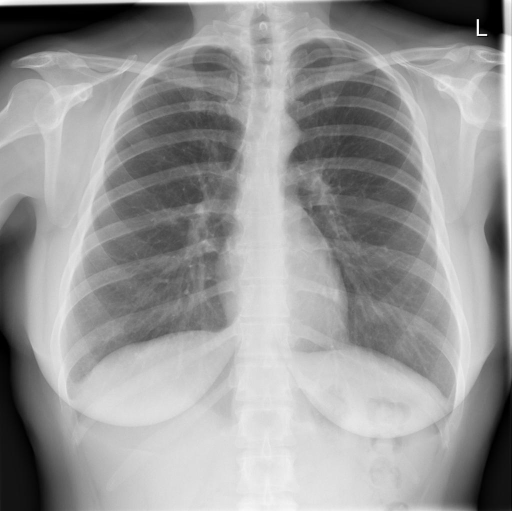

In [40]:

print("Findings for below image is :" , data.at[2,'findings'])
img = cv2.imread(data.at[2,'image1'], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)


Findings for below image is : the heart and lungs have in the interval. both lungs are clear and epanded. heart and mediastinum normal.


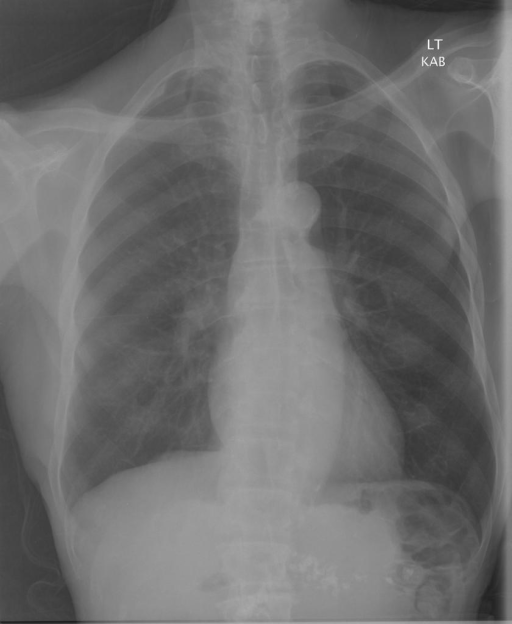

In [41]:

print("Findings for below image is :" , data.at[9,'findings'])
img = cv2.imread(data.at[9,'image1'], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)


<h3> 3.2.8 Loading pretrained chexnet model <h3>

In [42]:
url = 'https://drive.google.com/uc?id=19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b'
output = 'chexnet.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=19BllaOvs2x5PLV_vlWMy4i8LapLb2j6b
To: /content/chexnet.h5
29.1MB [00:00, 86.0MB/s]


'chexnet.h5'

In [43]:

#chex = DenseNet121(include_top=False, weights = None, input_shape=(224,224,3))

In [44]:
chexnet = DenseNet121(weights=cwd+'/chexnet.h5',
                                                classes = 14,input_shape=(224,224,3))

In [45]:
#model.load_weights('chexnet.h5')

In [46]:

model = Model(chexnet.input, chexnet.layers[-2].output)

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

<h3> 3.2.7 Extracting the features from images <h3>

In [48]:
def load_image(img_name):
  """Loads image in array format"""

  image = Image.open(img_name)
  X = np.asarray(image.convert("RGB"))
  X = np.asarray(X)
  X = preprocess_input(X)
  X = resize(X, (224,224,3))
  X = np.expand_dims(X, axis=0)
  X = np.asarray(X)
    
  return X

In [49]:
image1_paths = data['image1'].astype(str).tolist()
image2_paths = data['image2'].astype(str).tolist()

In [64]:
image_features = []
for i in tqdm(range(len(image1_paths))):

  #image 1
  i1 = load_image(image1_paths[i])
  img1_features = model.predict(i1)
  img1_features = np.vstack(img1_features).astype(np.float)


  #image 2
  i2 = load_image(image2_paths[i])
  img2_features = model.predict(i2)
  img2_features = np.vstack(img2_features).astype(np.float)

  conc = np.concatenate((img1_features, img2_features), axis=1)
  #conc = tf.reshape(conc, (conc.shape[0], -1, conc.shape[-1]))

  image_features.append(conc)



In [65]:
data['image_features'] =image_features

<h3> 3.2.7 Adding start and end tokens <h3>

In [67]:
#Adding start and End tokens

#data.combined_text ='<start>' + ' ' + data.combined_text.astype(str) + ' '+'<end>'
data['findings_total'] = '<start>' + ' ' + data.findings.astype(str) + ' ' +'<end>'
data['dec_ip'] = '<start>' + ' ' + data.findings.astype(str)  #Decoder input
data['dec_op'] = data.findings.astype(str) + ' ' +'<end>'     #dDecoder output

In [68]:
data.head()

,patient_id,image1,image2,findings,image_features,findings_total,dec_ip,dec_op
0,CXR3556,/content/png/CXR3556_IM-1741-1001-0001.png,/content/png/CXR3556_IM-1741-1001-0002.png,the lungs are clear. there is no pleural effus...,"[[0.00041582860285416245, 0.001570420921780169...",<start> the lungs are clear. there is no pleur...,<start> the lungs are clear. there is no pleur...,the lungs are clear. there is no pleural effus...
2,CXR32,/content/png/CXR32_IM-1511-1001.png,/content/png/CXR32_IM-1511-4001.png,the heart is normal in size. the mediastinum i...,"[[0.0005354544264264405, 0.0019668142776936293...",<start> the heart is normal in size. the media...,<start> the heart is normal in size. the media...,the heart is normal in size. the mediastinum i...
4,CXR260,/content/png/CXR260_IM-1090-1001.png,/content/png/CXR260_IM-1090-2001.png,lungs are clear bilaterally. cardiac and media...,"[[0.0002745636156760156, 0.0018877924885600805...",<start> lungs are clear bilaterally. cardiac a...,<start> lungs are clear bilaterally. cardiac a...,lungs are clear bilaterally. cardiac and media...
5,CXR1301,/content/png/CXR1301_IM-0198-1001.png,/content/png/CXR1301_IM-0198-2001.png,"heart size within normal limits, stable medias...","[[0.0005874697235412896, 0.0018448150949552655...","<start> heart size within normal limits, stabl...","<start> heart size within normal limits, stabl...","heart size within normal limits, stable medias..."
6,CXR1921,/content/png/CXR1921_IM-0598-1001.png,/content/png/CXR1921_IM-0598-2001.png,"redemonstration of moderately-inflated lungs, ...","[[0.00029747304506599903, 0.0014215346891433, ...",<start> redemonstration of moderately-inflated...,<start> redemonstration of moderately-inflated...,"redemonstration of moderately-inflated lungs, ..."


In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
data.to_pickle('final_1024.pkl') 

In [74]:
!cp -r /content/final_1024.pkl /content/drive/MyDrive

In [ ]:
#https://drive.google.com/file/d/1GLQ1G0K9uH1WiXEdasqjjMyT9pmI_L1Z/view?usp=sharing   98/1024
#https://drive.google.com/file/d/1U7D9lnjH-0CaXzhmua2rMtmdgS4DEH2k/view?usp=sharing    1024